In [22]:
import tensorflow as tf
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout , Conv1D , GlobalMaxPool1D
from keras.preprocessing import text, sequence
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.utils.data_utils import pad_sequences
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


In [2]:
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true['truth'] = 1
fake['truth'] = 0
df = pd.concat([true, fake], axis=0, ignore_index=True)
df.shape

(44898, 5)

In [ ]:
def clean_text(txt):
   
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)
    
    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
df['data_cleaned'] = df['title'].apply(lambda txt: clean_text(txt))


In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(df['data_cleaned'], df['truth'], shuffle=True, test_size=0.2)
# find the length of the largest sentence in training data
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 227


In [7]:
max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)

# pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

# print('Text Example:', xtrain[0])
# print('Sequence of indices(before padding):', xtrain_seq[0])
# print('Sequence of indices(after padding):', xtrain_pad[0])

# Word embedding using pre-trained GloVe vectors


In [40]:
embedding_vectors = {}
with open('glove.twitter.27B.100d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   


Size of vocabulary in GloVe: 1193514


In [9]:
#initialize the embedding_matrix with zeros
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)

print(f'Some out of valubulary words: {oov_words[0:5]}')

Some out of valubulary words: ['brexit', 'antitrump', 'tillerson', 'kellyanne', 'reutersipsos']


In [23]:
def eval_model(true_value, predict_value):
    print("accuracy:  ", accuracy_score(true_value, predict_value))
    print("Precision:  ", precision_score(true_value, predict_value))
    print("Recall:  ", recall_score(true_value, predict_value))
    print("F1 score:  ", f1_score(true_value, predict_value))

In [39]:
print(xtest_pad.shape)
print(ytest.shape)
print(xtrain_pad.shape)
print(ytrain.shape)

(8980, 227)
(8980,)
(35918, 227)
(35918,)


## LSTM


In [10]:
vocab_len

10000

In [12]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dense(32, activation = 'sigmoid'))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,145,217
Trainable params: 145,217
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [13]:
batch_size = 256
epochs  = 10
history = lstm_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Epoch 1/10
141/141 [==============================] - 318s 2s/step - loss: 0.1909 - accuracy: 0.9252 - val_loss: 0.1106 - val_accuracy: 0.9665
Epoch 2/10
141/141 [==============================] - 270s 2s/step - loss: 0.0878 - accuracy: 0.9728 - val_loss: 0.0804 - val_accuracy: 0.9742
Epoch 3/10
141/141 [==============================] - 315s 2s/step - loss: 0.0689 - accuracy: 0.9784 - val_loss: 0.0664 - val_accuracy: 0.9788
Epoch 4/10
141/141 [==============================] - 296s 2s/step - loss: 0.0552 - accuracy: 0.9822 - val_loss: 0.0573 - val_accuracy: 0.9818
Epoch 5/10
141/141 [==============================] - 286s 2s/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0601 - val_accuracy: 0.9813
Epoch 6/10
141/141 [==============================] - 270s 2s/step - loss: 0.0390 - accuracy: 0.9881 - val_loss: 0.0539 - val_accuracy: 0.9833
Epoch 7/10
141/141 [==============================] - 280s 2s/step - loss: 0.0321 - accuracy: 0.9909 - val_loss: 0.0494 - val_accuracy: 0.9854

In [14]:
lstm_model.save("lstm_model_isot.h5")

In [19]:
# load model
# model = load_model('lstm_model_isot.h5')
# # summarize model.
# model.summary()


Text(0.5, 1.0, 'Accuracy')

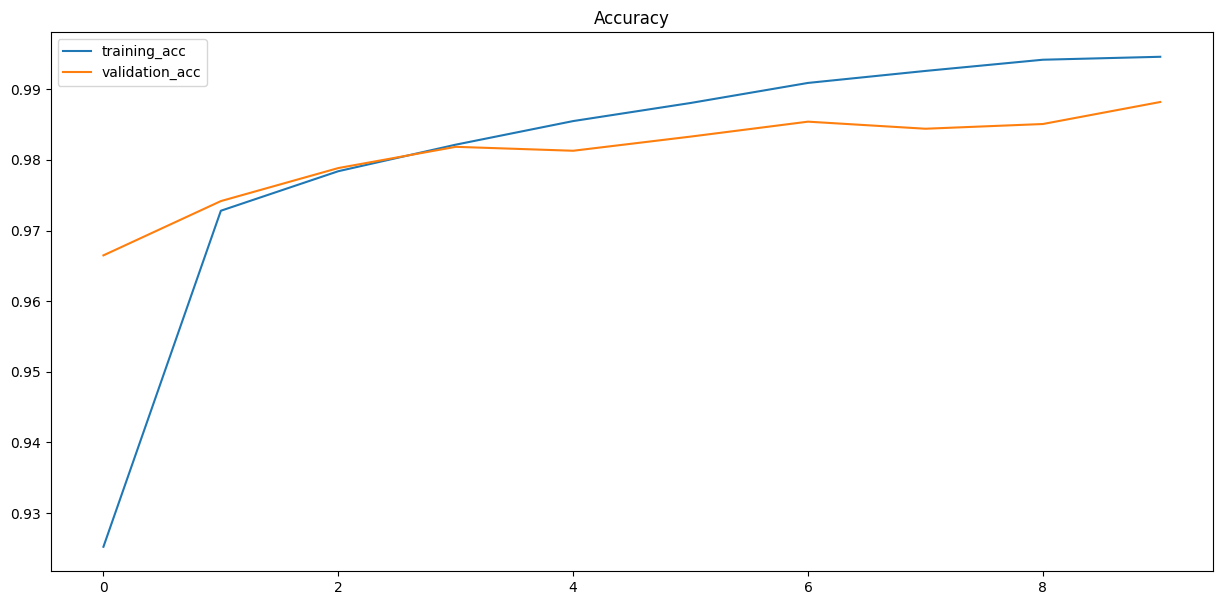

In [15]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [29]:
predict_y = lstm_model.predict(xtest_pad)
eval_model(np.array(ytest).astype(int), predict_y.round())

281/281 [==============================] - 15s 54ms/step
accuracy:   0.9881959910913141
Precision:   0.9827021972884525
Recall:   0.9924457034938622
F1 score:   0.987549917782476


## GRU

In [30]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 88,449
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [31]:
batch_size = 256
epochs  = 10
history = gru_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Epoch 1/10
141/141 [==============================] - 72s 498ms/step - loss: 0.1552 - accuracy: 0.9404 - val_loss: 0.0912 - val_accuracy: 0.9698
Epoch 2/10
141/141 [==============================] - 99s 701ms/step - loss: 0.0809 - accuracy: 0.9731 - val_loss: 0.0740 - val_accuracy: 0.9733
Epoch 3/10
141/141 [==============================] - 96s 678ms/step - loss: 0.0648 - accuracy: 0.9779 - val_loss: 0.0631 - val_accuracy: 0.9776
Epoch 4/10
141/141 [==============================] - 94s 667ms/step - loss: 0.0538 - accuracy: 0.9817 - val_loss: 0.0531 - val_accuracy: 0.9811
Epoch 5/10
141/141 [==============================] - 92s 650ms/step - loss: 0.0438 - accuracy: 0.9848 - val_loss: 0.0563 - val_accuracy: 0.9808
Epoch 6/10
141/141 [==============================] - 90s 639ms/step - loss: 0.0360 - accuracy: 0.9870 - val_loss: 0.0466 - val_accuracy: 0.9853
Epoch 7/10
141/141 [==============================] - 93s 659ms/step - loss: 0.0286 - accuracy: 0.9897 - val_loss: 0.0429 - val_ac

In [32]:
gru_model.save("gru_model_isot.h5")

Text(0.5, 1.0, 'Accuracy')

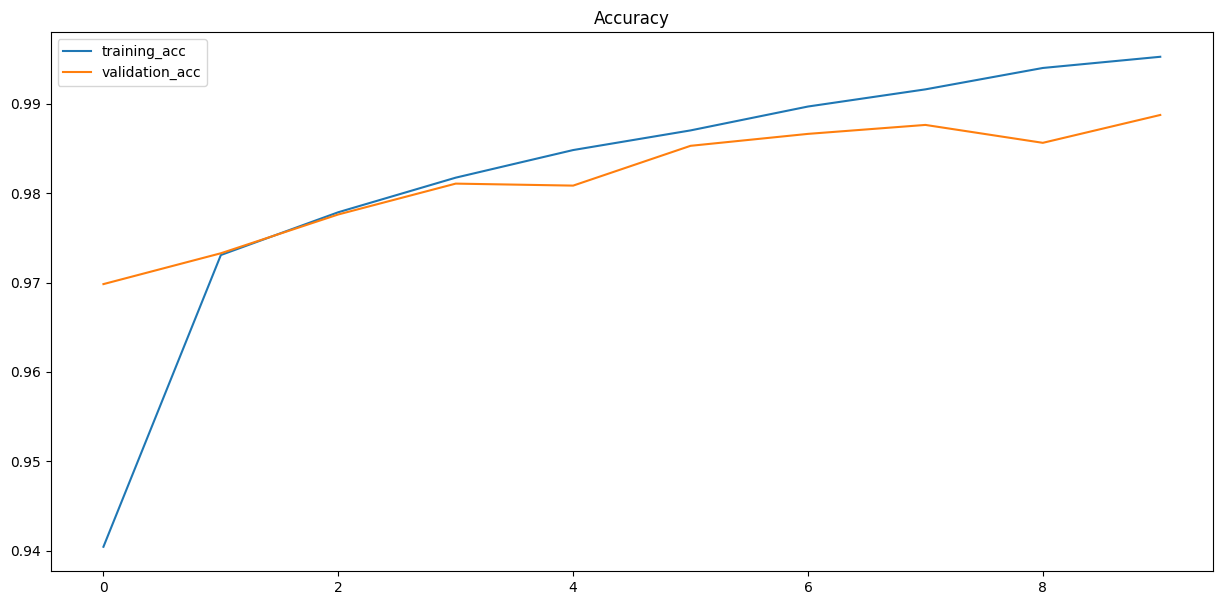

In [33]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [34]:
predict_y = gru_model.predict(xtest_pad)
eval_model(np.array(ytest).astype(int), predict_y.round())

281/281 [==============================] - 8s 26ms/step
accuracy:   0.9887527839643653
Precision:   0.9868142218036261
Recall:   0.9893767705382436
F1 score:   0.98809383472828


## CNN

In [35]:
emb_dim = embedding_matrix.shape[1]
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(128 , kernel_size=4))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(128, activation = 'sigmoid'))
cnn_model.add(Dense(1, activation = 'sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         51328     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                      

In [36]:
batch_size = 256
epochs  = 10
history = cnn_model.fit(xtrain_pad, np.asarray(ytrain), validation_data=(xtest_pad, np.asarray(ytest)), batch_size = batch_size, epochs = epochs)


Epoch 1/10
141/141 [==============================] - 15s 102ms/step - loss: 0.2126 - accuracy: 0.9213 - val_loss: 0.1044 - val_accuracy: 0.9657
Epoch 2/10
141/141 [==============================] - 15s 104ms/step - loss: 0.1024 - accuracy: 0.9636 - val_loss: 0.0813 - val_accuracy: 0.9720
Epoch 3/10
141/141 [==============================] - 24s 167ms/step - loss: 0.0834 - accuracy: 0.9708 - val_loss: 0.0704 - val_accuracy: 0.9755
Epoch 4/10
141/141 [==============================] - 16s 115ms/step - loss: 0.0688 - accuracy: 0.9759 - val_loss: 0.0718 - val_accuracy: 0.9747
Epoch 5/10
141/141 [==============================] - 15s 107ms/step - loss: 0.0595 - accuracy: 0.9793 - val_loss: 0.0543 - val_accuracy: 0.9797
Epoch 6/10
141/141 [==============================] - 14s 103ms/step - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.0591 - val_accuracy: 0.9784
Epoch 7/10
141/141 [==============================] - 14s 103ms/step - loss: 0.0447 - accuracy: 0.9842 - val_loss: 0.0557 - val_ac

In [37]:
cnn_model.save("cnn_model_isot.h5")

Text(0.5, 1.0, 'Accuracy')

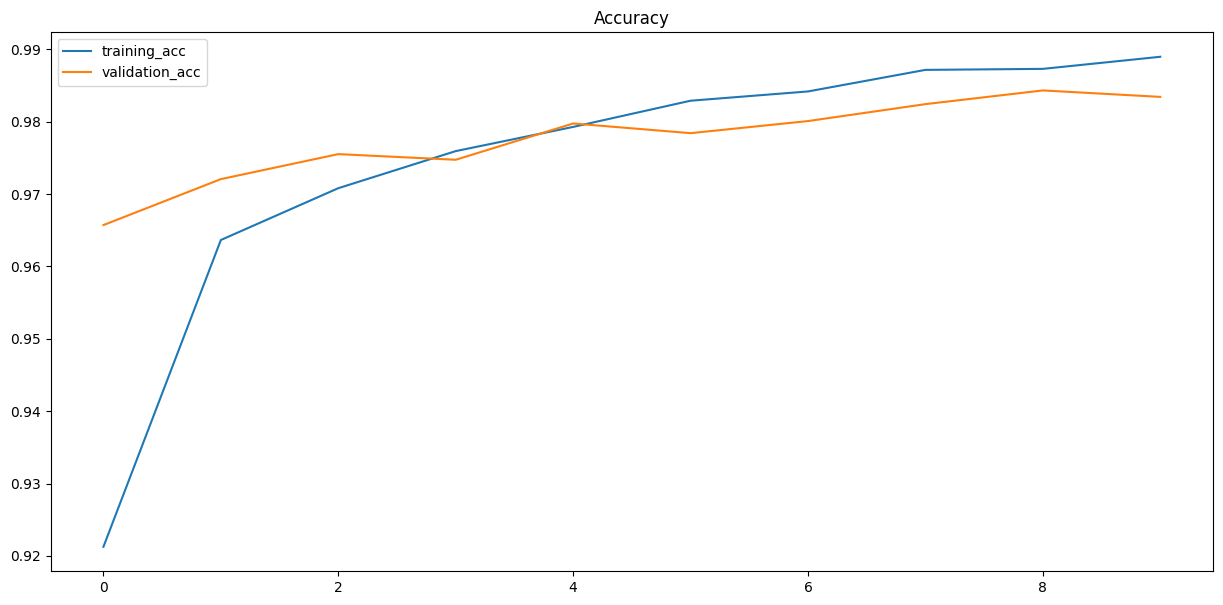

In [41]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [38]:
predict_y = cnn_model.predict(xtest_pad)
eval_model(np.array(ytest).astype(int), predict_y.round())

281/281 [==============================] - 1s 5ms/step
accuracy:   0.9834075723830735
Precision:   0.971830985915493
Recall:   0.9936260623229461
F1 score:   0.9826076806349947
